In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
import re
from gan_model import Generator, Discriminator, Regressor
import dataset_utils
from sklearn.manifold import TSNE

/home/grinenko/anaconda3/envs/anna/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
soft = ['35_21_1000.Q.KatKlD.1444.octanI', '35_21_1000.Q.KatKlAB.DavNpar', '35_21_1000.Q.KatKlAB.EBen70', '35_21_1000.Q.KatKlAB.AroPf.v']
K = 60 #усреднение
SOFT_SENSOR_INDEX = 3
W=5
SOFT_SENSOR_NAME = soft[SOFT_SENSOR_INDEX]
PERIODS_FILE = "periods_W20_gr{}_Agl.npy".format(K)

In [3]:
data = pd.read_csv("Dataset1_nans.csv", sep=";")
soft_data = data[soft].copy()
data_orig = data.drop(soft + ['Timestamp'], axis=1)

In [4]:
dataset = dataset_utils.Dataset(data_orig, soft_data[SOFT_SENSOR_NAME], K=K, diff=False, periods=None)
# dataset = dataset_utils.Dataset(data_orig, soft_data[SOFT_SENSOR_NAME], K=K, diff=False, periods=None)
dataset_x, dataset_y, y_scaler = dataset.window_view(W=W, scale_target=True)

window_view: (867, 5, 57) (867,)


In [5]:
N = dataset_x.shape[0]

In [8]:
# G = Generator(input_shape=2, output_shape=dataset_x.shape[1:])
# PATH = "gan_results/models/" + "2_W5_G_1.pth"
PATH = "gan_results/models/" + "2_W5_mlp3_G_0.pth"
G = Generator(input_shape=1, output_shape=dataset_x.shape[1:])
G.load_state_dict(torch.load(PATH))
G.eval()

Generator(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=285, bias=True)
    (unflatten): Unflatten(dim=-1, unflattened_size=(5, 57))
  )
)

In [18]:
syn_data = []
M = 10
for i in range(len(dataset_x)):
    z = torch.tensor(np.random.normal(loc=5, scale=2, size=M)).float()[..., None]
    y_inp = torch.tensor([dataset_y[i]] * M).float()
    syn_data.append(G(z, y_inp))
syn_data = torch.concat(syn_data, dim=0).flatten(start_dim=1).detach().numpy()


In [19]:
#for each elem 
X = np.repeat(dataset_x.reshape(dataset_x.shape[0], -1), M, axis=0)
syn_X = syn_data
mean_dist = np.linalg.norm(syn_X - X, axis=1)
np.mean(mean_dist)

50.0302323298805

In [20]:
real_var = np.mean(np.linalg.norm(X, axis=1))
np.mean(mean_dist) / real_var

5.062745849712978

In [21]:
mask = np.zeros(X.shape[0] * 2)
mask[X.shape[0]:] = 1
all_X = np.concatenate([syn_X, X[::M]], axis=0)
all_X.shape

(9537, 285)

In [22]:
X_emb = TSNE().fit_transform(all_X)

/home/grinenko/anaconda3/envs/anna/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/grinenko/anaconda3/envs/anna/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


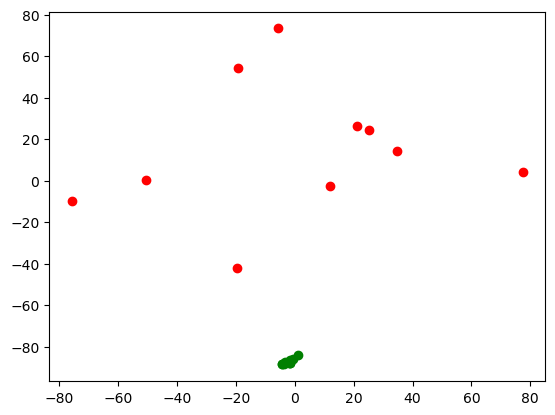

In [23]:
plt.scatter(X_emb[: N * M, 0][:10], X_emb[: N * M, 1][:10], color="red")
plt.scatter(X_emb[N * M:, 0][:10], X_emb[N * M:, 1][:10], color="green")

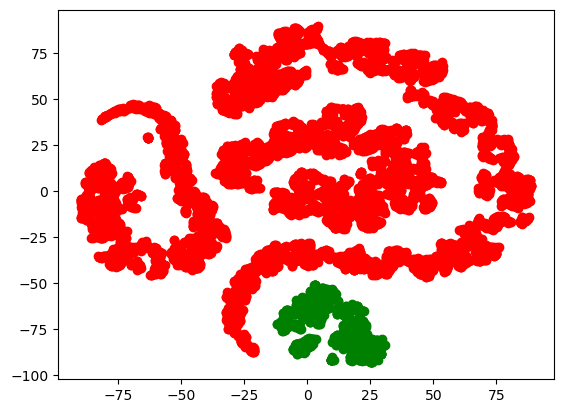

In [24]:
plt.scatter(X_emb[: N * M, 0], X_emb[: N * M, 1], color="red")
plt.scatter(X_emb[N * M:, 0], X_emb[N * M:, 1], color="green")